In [23]:
import pandas as pd
import numpy as np

# libraries for performing NLP 

import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn import preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from keras.layers import LSTM
from keras.models import Model
from tensorflow.keras.layers import concatenate


from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#fake news dataset

data=pd.read_excel('sample.xlsx')

In [3]:
data.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,rumor
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,rumor
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",rumor
3,Trump Is So Obsessed He Even Has Obamaâ€™s Na...,"On Christmas day, Donald Trump announced that ...",rumor
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,rumor


In [4]:
# remove rows with null values in the "text" column
data = data.dropna(subset=["text"])

# save the modified dataset
data.to_excel("sample3.xlsx", index=False)

In [5]:
data=pd.read_excel('sample3.xlsx')

In [6]:
# Mapping Values for labels  

le=preprocessing.LabelEncoder()
data['label']=le.fit_transform(data['label'])

In [7]:
non_rumor=data[data['label']==0]
rumor=data[data['label']==1]

In [8]:
#count each label

data.label.value_counts()

1    23501
0    21417
Name: label, dtype: int64

In [9]:
#balancing data

under_rumor=rumor.sample(21417,axis=0)
balanced_data=pd.concat([non_rumor,under_rumor])


In [10]:
balanced_data.shape

(42834, 3)

In [11]:
balanced_data.label.value_counts()

0    21417
1    21417
Name: label, dtype: int64

In [4]:
#preprocessing

def clean_text(text):
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

In [13]:
balanced_data['title']=balanced_data['title'].apply(clean_text)
balanced_data['text']=balanced_data['text'].apply(clean_text)

In [14]:
print (balanced_data)

                                                   title  \
23501  As U.S. budget fight looms, Republicans flip t...   
23502  U.S. military to accept transgender recruits o...   
23503  Senior U.S. Republican senator: 'Let Mr. Muell...   
23504  FBI Russia probe helped by Australian diplomat...   
23505  Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
22298      Boiler Room #91 â€“ The Swear Jar Overfloweth   
19970  DEPLORABLE! HILLARYâ€™S Campaign Is In PANIC M...   
10550  LORETTA LYNCHâ€™S â€œBehaviorâ€ in 2016 Elect...   
21621  [VIDEO] HECKLERS TAUNT HILLARY AT CAMPAIGN STO...   
22653  Attack on Trump: Mitt Romney Just â€˜Awoke a S...   

                                                    text  label  
23501  WASHINGTON (Reuters) - The head of a conservat...      0  
23502  WASHINGTON (Reuters) - Transgender people will...      0  
23503  WASHINGTON (Reuters) - The special counsel inv...      0  
23504  WASHINGT

In [5]:
def convert_lower(text): 
  return text.lower()

In [16]:
balanced_data['title']=balanced_data['title'].apply(convert_lower)
balanced_data['text']=balanced_data['text'].apply(convert_lower)

In [6]:
def remove_special(text):
  x=' '

  for i in text:
    if i.isalnum():
      x=x+i
    else:
      x=x + ' '
  return x

In [18]:
balanced_data['title']=balanced_data['title'].apply(remove_special)
balanced_data['text']=balanced_data['text'].apply(remove_special)
balanced_data

,title,text,label
23501,as u s budget fight looms republicans flip ...,washington reuters the head of a conserva...,0
23502,u s military to accept transgender recruits ...,washington reuters transgender people wil...,0
23503,senior u s republican senator let mr muel...,washington reuters the special counsel in...,0
23504,fbi russia probe helped by australian diploma...,washington reuters trump campaign adviser...,0
23505,trump wants postal service to charge much mo...,seattle washington reuters president dona...,0
...,...,...,...
22298,boiler room 91 â the swear jar overfloweth,tune in to the alternate current radio networ...,1
19970,deplorable hillaryâ s campaign is in panic ...,what happens when hillary s poll numbers take...,1
10550,loretta lynchâ s â œbehaviorâ in 2016 elec...,it s about time the senate judiciary committe...,1
21621,video hecklers taunt hillary at campaign st...,hillary got a bit of a surprise while leaving...,1


In [7]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

In [20]:
balanced_data['title']=balanced_data['title'].apply(rem_stopwords)
balanced_data['text']=balanced_data['text'].apply(rem_stopwords)

In [21]:
balanced_data

,title,text,label
23501,"[u, budget, fight, looms, republicans, flip, f...","[washington, reuters, head, conservative, repu...",0
23502,"[u, military, accept, transgender, recruits, m...","[washington, reuters, transgender, people, all...",0
23503,"[senior, u, republican, senator, let, mr, muel...","[washington, reuters, special, counsel, invest...",0
23504,"[fbi, russia, probe, helped, australian, diplo...","[washington, reuters, trump, campaign, adviser...",0
23505,"[trump, wants, postal, service, charge, much, ...","[seattle, washington, reuters, president, dona...",0
...,...,...,...
22298,"[boiler, room, 91, â, swear, jar, overfloweth]","[tune, alternate, current, radio, network, acr...",1
19970,"[deplorable, hillaryâ, campaign, panic, modeâ,...","[happens, hillary, poll, numbers, take, nose, ...",1
10550,"[loretta, lynchâ, â, œbehaviorâ, 2016, electio...","[time, senate, judiciary, committee, opened, p...",1
21621,"[video, hecklers, taunt, hillary, campaign, st...","[hillary, got, bit, surprise, leaving, campaig...",1


In [8]:
wnl=WordNetLemmatizer()
y=[]
def lemma(text):
    for i in text:
      y.append(wnl.lemmatize(i))
    z=y[:]
    y.clear()
    return z

In [23]:
balanced_data['title']=balanced_data['title'].apply(lemma)

In [24]:
balanced_data['text']=balanced_data['text'].apply(lemma)

In [25]:
balanced_data

,title,text,label
23501,"[u, budget, fight, loom, republican, flip, fis...","[washington, reuters, head, conservative, repu...",0
23502,"[u, military, accept, transgender, recruit, mo...","[washington, reuters, transgender, people, all...",0
23503,"[senior, u, republican, senator, let, mr, muel...","[washington, reuters, special, counsel, invest...",0
23504,"[fbi, russia, probe, helped, australian, diplo...","[washington, reuters, trump, campaign, adviser...",0
23505,"[trump, want, postal, service, charge, much, a...","[seattle, washington, reuters, president, dona...",0
...,...,...,...
22298,"[boiler, room, 91, â, swear, jar, overfloweth]","[tune, alternate, current, radio, network, acr...",1
19970,"[deplorable, hillaryâ, campaign, panic, modeâ,...","[happens, hillary, poll, number, take, nose, d...",1
10550,"[loretta, lynchâ, â, œbehaviorâ, 2016, electio...","[time, senate, judiciary, committee, opened, p...",1
21621,"[video, heckler, taunt, hillary, campaign, sto...","[hillary, got, bit, surprise, leaving, campaig...",1


In [9]:
def join_back(list_input):
 return " ".join(list_input)

In [27]:
balanced_data['title']=balanced_data['title'].apply(join_back)
balanced_data['text']=balanced_data['text'].apply(join_back)

In [33]:
balanced_data

,title,text,label
23501,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,0
23502,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,0
23503,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,0
23504,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,0
23505,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,0
...,...,...,...
22298,boiler room 91 â swear jar overfloweth,tune alternate current radio network acr anoth...,1
19970,deplorable hillaryâ campaign panic modeâ lates...,happens hillary poll number take nose dive cau...,1
10550,loretta lynchâ â œbehaviorâ 2016 election inve...,time senate judiciary committee opened probe f...,1
21621,video heckler taunt hillary campaign stop â œw...,hillary got bit surprise leaving campaign stop...,1


In [34]:
balanced_data.to_excel('rumor_s.xlsx')

In [24]:
data=pd.read_excel('rumor_s.xlsx')

In [25]:
data.head()

,Unnamed: 0,title,text,label
0,23501,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,0
1,23502,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,0
2,23503,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,0
3,23504,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,0
4,23505,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,0


In [26]:
# drop the unwanted columns

to_drop=["Unnamed: 0"]
data=data.drop(data[to_drop],axis=1)

In [27]:
data.label.value_counts()

0    21417
1    21417
Name: label, dtype: int64

In [28]:
#dropping null rows
data=data.dropna()

In [29]:
data.label.value_counts()

0    21416
1    20849
Name: label, dtype: int64

In [30]:
 # split the dataset
    
train,test=train_test_split(data,random_state=42,test_size=0.2)

#check the shape of data

train.shape,test.shape

((33812, 3), (8453, 3))

In [9]:
# feature extraction

In [10]:
# Tokenize the text and title inputs separately

text_tokenizer = Tokenizer(num_words=10000)
text_tokenizer.fit_on_texts(train['text'].values)
title_tokenizer = Tokenizer(num_words=10000)
title_tokenizer.fit_on_texts(train['title'].values)

In [11]:
# Convert text and title inputs to sequences

train_text_seq = text_tokenizer.texts_to_sequences(train['text'].values)
train_title_seq = title_tokenizer.texts_to_sequences(train['title'].values)

In [14]:
# save text_tokenizer

with open('text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save title_tokenizer

with open('title_tokenizer.pickle', 'wb') as handle:
    pickle.dump(title_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# Apply padding to make the sequences of equal length

max_length_text = 200
max_length_title = 50
train_text = pad_sequences(train_text_seq, maxlen=max_length_text)
train_title = pad_sequences(train_title_seq, maxlen=max_length_title)

In [15]:
# Load pre-trained GloVe word embeddings

embeddings_index = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [16]:
# Create embedding matrices for text and title inputs

embedding_dim = 300
text_word_index = text_tokenizer.word_index
num_words_text = min(10000, len(text_word_index) + 1)
text_embedding_matrix = np.zeros((num_words_text, embedding_dim))
for word, i in text_word_index.items():
    if i >= num_words_text:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        text_embedding_matrix[i] = embedding_vector

title_word_index = title_tokenizer.word_index
num_words_title = min(10000, len(title_word_index) + 1)
title_embedding_matrix = np.zeros((num_words_title, embedding_dim))
for word, i in title_word_index.items():
    if i >= num_words_title:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        title_embedding_matrix[i] = embedding_vector

In [17]:
# Define the model architecture

text_input = Input(shape=(max_length_text,), name='text_input')
title_input = Input(shape=(max_length_title,), name='title_input')
text_embedding = Embedding(num_words_text, embedding_dim,
                           input_length=max_length_text, trainable=False)(text_input)
title_embedding = Embedding(num_words_title, embedding_dim,
                            input_length=max_length_title, trainable=False)(title_input)
text_lstm = LSTM(32)(text_embedding)
title_lstm = LSTM(32)(title_embedding)
concatenated = concatenate([text_lstm, title_lstm], axis=-1)
output = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=[text_input, title_input], outputs=output)


In [18]:
# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model

history=model.fit([train_text, train_title], train['label'], epochs=4, batch_size=32, validation_split=0.2)

Epoch 1/4
846/846 [==============================] - 139s 151ms/step - loss: 0.1808 - accuracy: 0.9331 - val_loss: 0.1318 - val_accuracy: 0.9493
Epoch 2/4
846/846 [==============================] - 108s 128ms/step - loss: 0.0797 - accuracy: 0.9729 - val_loss: 0.0913 - val_accuracy: 0.9672
Epoch 3/4
846/846 [==============================] - 107s 127ms/step - loss: 0.0538 - accuracy: 0.9808 - val_loss: 0.0417 - val_accuracy: 0.9845
Epoch 4/4
846/846 [==============================] - 109s 128ms/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.0438 - val_accuracy: 0.9870


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 title_input (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 300)     3000000     ['text_input[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 300)      3000000     ['title_input[0][0]']            
                                                                                              

In [22]:
# Save the model to a file

model.save('my_model.h5')

In [31]:
#load the saved model

model = load_model('my_model.h5')

In [32]:
# load text_tokenizer
with open('text_tokenizer.pickle', 'rb') as handle:
    text_tokenizer = pickle.load(handle)

# load title_tokenizer
with open('title_tokenizer.pickle', 'rb') as handle:
    title_tokenizer = pickle.load(handle)

In [33]:
max_length_text=200
max_length_title=50

In [34]:
# Evaluate the model on the test set

test_text_seq = text_tokenizer.texts_to_sequences(test['text'].values)
test_title_seq = title_tokenizer.texts_to_sequences(test['title'].values)
test_text = pad_sequences(test_text_seq, maxlen=max_length_text)
test_title = pad_sequences(test_title_seq, maxlen=max_length_title)

model.evaluate([test_text, test_title], test['label'])

265/265 [==============================] - 22s 64ms/step - loss: 0.0428 - accuracy: 0.9881


[0.04284543916583061, 0.9880515933036804]

In [35]:
# Evaluate the model on the validation set

loss, accuracy = model.evaluate([test_text, test_title], test['label'], batch_size=32)

# Print the evaluation metrics

print('Validation loss:', loss)
print('Validation accuracy:', accuracy)


265/265 [==============================] - 17s 64ms/step - loss: 0.0428 - accuracy: 0.9881
Validation loss: 0.04284543916583061
Validation accuracy: 0.9880515933036804


In [22]:

# Predict labels for the validation set
y_pred = model.predict([test_text, test_title])

# Convert predicted probabilities to binary labels
y_pred = np.round(y_pred)

# Print the classification report
print(classification_report(test['label'], y_pred))


265/265 [==============================] - 15s 52ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4285
           1       1.00      0.98      0.99      4168

    accuracy                           0.99      8453
   macro avg       0.99      0.99      0.99      8453
weighted avg       0.99      0.99      0.99      8453



In [23]:
test_text_seq = text_tokenizer.texts_to_sequences(test['text'].values)
test_title_seq = title_tokenizer.texts_to_sequences(test['title'].values)

# Apply padding to make the sequences of equal length
test_text = pad_sequences(test_text_seq, maxlen=max_length_text)
test_title = pad_sequences(test_title_seq, maxlen=max_length_title)

# Predict on test data
predictions = model.predict([test_text, test_title])

predicted_labels = [1 if val > 0.5 else 0 for val in predictions]
print(predicted_labels)


265/265 [==============================] - 14s 51ms/step
[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 

In [24]:
# Define y_test

y_test = test['label'].values

y_pred = model.predict([test_text, test_title])
y_pred = [1 if val > 0.5 else 0 for val in y_pred]
cm = confusion_matrix(y_test, y_pred)
print(cm)


265/265 [==============================] - 14s 52ms/step
[[4265   20]
 [  81 4087]]


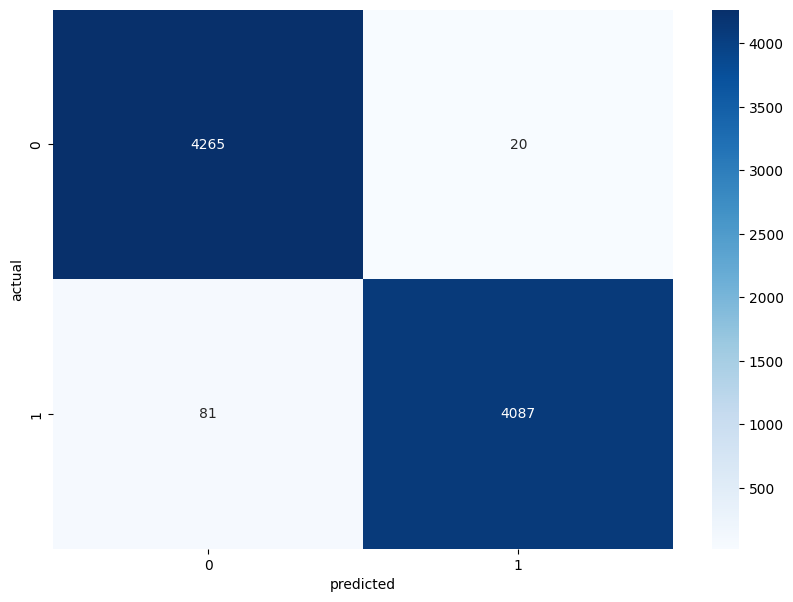

In [25]:
#the heat map

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

In [45]:

# Make predictions on new data
new_texts = ['Noor Jehan, an elephant in Pakistan’s Karachi Zoo, is critically ill after the 17-year-old fell in a pond on Thursday in a small enclosure.Right after the fall Four Paws, a global animal welfare organization, recommended lifting Noor Jehan with a crane, ropes and belts. She has since been lying visibly weak with limited motion on a mound of sand, propped up against the only tree inside the enclosure.“Her condition is very critical at the moment. We are trying everything to save her,” Four Paws spokeswoman Katharina Braun said by email. “It is very important that she gets up as soon as possible, laying too long on the ground… can be life threatening.”Noor Jehan is suffering from a huge hematoma, or pool of clotted blood, inside her abdomen in addition to intestinal issues, Four Paws member Dr. Amir Khalil said during his visit to treat her last week. The veterinarian from Egypt had then given Noor Jehan a strong chance of survival.Khalid Hashmi was removed as director of Karachi Zoo on April 8 over complaints of negligence.His successor, Kanwar Ayub, said he was unsure if the complaints were true in the week following the vet’s visit. “However, there has been no negligence in the three days I have been appointed, guaranteed,” he said on Friday, noting possible negligence over time.']

new_titles = [' Elephant Noor Jehan critically ill at Karachi Zoo after fall']


In [46]:
# print(new_texts)


new_text_seq = text_tokenizer.texts_to_sequences(new_texts)
new_title_seq = title_tokenizer.texts_to_sequences(new_titles)

# print("before padding", len(new_text_seq[0]))

new_text = pad_sequences(new_text_seq, maxlen=max_length_text)
new_title = pad_sequences(new_title_seq, maxlen=max_length_title)

# print("after padding",len(new_text[0]))

predictions = model.predict([new_text, new_title])

# print(predictions)

for i in range(len(predictions)):
    if predictions[i] > 0.5:
        print(f"Text '{new_texts[i]}' and Title '{new_titles[i]}' is predicted as rumor.")
    else:
        print(f"Text '{new_texts[i]}' and Title '{new_titles[i]}' is predicted as non-rumor.")

1/1 [==============================] - 1s 578ms/step
Text 'Noor Jehan, an elephant in Pakistan’s Karachi Zoo, is critically ill after the 17-year-old fell in a pond on Thursday in a small enclosure.Right after the fall Four Paws, a global animal welfare organization, recommended lifting Noor Jehan with a crane, ropes and belts. She has since been lying visibly weak with limited motion on a mound of sand, propped up against the only tree inside the enclosure.“Her condition is very critical at the moment. We are trying everything to save her,” Four Paws spokeswoman Katharina Braun said by email. “It is very important that she gets up as soon as possible, laying too long on the ground… can be life threatening.”Noor Jehan is suffering from a huge hematoma, or pool of clotted blood, inside her abdomen in addition to intestinal issues, Four Paws member Dr. Amir Khalil said during his visit to treat her last week. The veterinarian from Egypt had then given Noor Jehan a strong chance of surviv